<a href="https://colab.research.google.com/github/chicago-cdac/2022-bpi-clinic/blob/vincent-liu-bpi/crime_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning Chicago Crime Data

I have downloaded the dataset from [the City of Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2). The data includes all crime information occurred in Chicago since 2001 AND recorded by CPD's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. The data is broken down by factors such as time, crime id, offense type, arrest, and crime location. 

The end purpose of this notebook is to fully clean the data, possibly by developing a pipeline, and to reduce difficulties in future analysis and visualization. This outcome is achieved through three steps: in step 1, we condense the dataset by truancating crimes that happened before 2015; in step 2, we clean the simplified data by transforming variable types and deselecting unnecessary information, and lastly, in step 3, we produce summary tables and graphs. 


## Step 0: Loading libraries

We will use `json` and `requests` for basic data gathering, `pandas` and `numpy` for data cleaning and wrangling, and `matplotlib` and `seaborn` for visualization.

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/BPI/"

Mounted at /content/drive


## Part I: Initial Data Cleaning

Before moving to any analysis, I need to cut out the data size to only include data from year 2015 in order to be consistent with the time frame in other data of this project. To do that, I filtered the data by variable `Year` and save the new, filtered dataset in the `data` subdirectory.

In [ ]:
crime_all_data = pd.read_csv("Crimes_2001_to_Present.csv")

Our dataframe has over 7M data and 20+ variables!! Thinking about the space needed to store these 7M data, this is clearly too many rows. With this large data size, transforming the data will also be very time-consuming. We surely don't want to spend hours waiting for the codes to run, right? We thus need to reduce the dimension by filtering out data that is out of scope of our analysis.

In [ ]:
crime_all_data.shape

(7642176, 22)

In [ ]:
crime_all_data[crime_all_data.Year >= 2015].to_csv("data/crimes_from_2015.csv", index= False)

## Part II Data Cleaning and Wrangling

After getting the dataset that has gone through dimension reduction steps, now is a great time to peak at our data! What information does the data provide? How many people were arrested during the time frame? Which year has the most crimes in Chicago? What's the most occurred crime type? Which police district had the most crimes and arrests? These are just some of the many questions we can think of.

But first, let's look at our data! What are these 22 variables? We use the first 10 rows to grasp a sense of what our data looks like.

In [ ]:
crimes = pd.read_csv("data/crimes_from_2015.csv")

c:\Users\liu00\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
import pickle

with open(path + 'cleaned_crimes_from_2015.pkl', 'rb') as f:
    crimes = pickle.load(f)
crimes.head(5)

,Case Number,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
0,HY411648,2015-09-05 13:30:00,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9,12,61,2015,41.815117,-87.670000
1,HY411615,2015-09-04 11:30:00,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15,29,25,2015,41.895080,-87.765400
2,JC213529,2018-09-01 00:01:00,THEFT,OVER $500,RESIDENCE,False,True,631,6,8,44,2018,NaN,NaN
3,HY411595,2015-09-05 12:45:00,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14,35,21,2015,41.937406,-87.716650
4,HY411610,2015-09-05 13:00:00,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15,28,25,2015,41.881903,-87.755121


In [6]:
crimes.dtypes

Case Number                     object
Date                    datetime64[ns]
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                         int32
Ward                             int32
Community Area                   int32
Year                             int64
Latitude                       float64
Longitude                      float64
dtype: object

In [7]:
district_pop = pd.read_csv(path+"2010population_by_district.csv")
district_pop = district_pop.iloc[:,[0,1]]
district_pop.columns = ["District", "2010_pop"]
district_pop.head(5)

,District,2010_pop
0,1,62781
1,2,95439
2,3,75235
3,4,123575
4,5,74396


In [8]:
district_pop.dtypes

District    int64
2010_Pop    int64
dtype: object

In [11]:
crimes = crimes.merge(district_pop, on='District', how='left')
crimes.head(5)

,Case Number,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude,2010_Pop
0,HY411648,2015-09-05 13:30:00,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9,12,61,2015,41.815117,-87.670000,165201
1,HY411615,2015-09-04 11:30:00,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15,29,25,2015,41.895080,-87.765400,59458
2,JC213529,2018-09-01 00:01:00,THEFT,OVER $500,RESIDENCE,False,True,631,6,8,44,2018,NaN,NaN,90841
3,HY411595,2015-09-05 12:45:00,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14,35,21,2015,41.937406,-87.716650,117738
4,HY411610,2015-09-05 13:00:00,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15,28,25,2015,41.881903,-87.755121,59458


Our data now has 1.9M rows. This is 3/4 down from the original dataset

In [ ]:
crimes.shape

(1923350, 22)

In [ ]:
crimes.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"


The 22 variables can be roughly grouped into a few categories:

| Category | Variables Belong to this Category|
| ------ | ------------------------|
| Crime| ID, Case Number |
| Crime Type and Info | IUCR, Primary Type, Description, Arrest, Domestic, FBI Code
| Time| Date, Year, Updated On|
| Location| Block, Location Description, Ward, Community Area|
| Police Area| Beat, District|
| Geographic Location| X Coordinate, Y Coordinate, Longitude, Latitude, Location|

These 22 variables own 4 data types: int65 (representing integer), (Pandas) object (this is pandas' way of calling strings, i.e. words), bool (booleans, i.e. T/F), and float (numbers with decimals). 

In [ ]:
crimes.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

As we are able to tell from the table above, there are a lot of overlaps on the information in each category. For example, `IUCR` and `FBI Code` represent the same type of crime but under distinct crime classification systems (IUCR stands for Illinois Uniform Crime Report), for which we can pick one of them. Similarily, `block`, `ward`, and `community areas` represent the same location on different scales. Moreover, some variables are related. For instance, because variables `primary type` and `description` are both explanations to the IUCR code, we can use the former twp to replace the latter, which gives us a more intuitive sense of the crime that corresponds to the case number. With this being known, within each category, we only need to pick variables that best characterize the information. These variables are:
  
| Category | Variables Belong to this Category|
| ------ | ------------------------|
| Crime| Case Number |
| Crime Type and Info |Primary Type, Description, Arrest, Domestic|
| Time| Date, Year|
| Location| Location Description, Ward, Community Area|
| Police Area| Beat, District|
| Geographic Location|Longitude, Latitude|

In [ ]:
crime = crimes.drop(["ID", "FBI Code", "Location", "Block", "IUCR", "Updated On", "X Coordinate", "Y Coordinate"], axis = 1)

crime.head(5)

,Case Number,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
0,HY411648,09/05/2015 01:30:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,2015,41.815117,-87.670000
1,HY411615,09/04/2015 11:30:00 AM,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,2015,41.895080,-87.765400
2,JC213529,09/01/2018 12:01:00 AM,THEFT,OVER $500,RESIDENCE,False,True,631,6.0,8.0,44.0,2018,NaN,NaN
3,HY411595,09/05/2015 12:45:00 PM,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,2015,41.937406,-87.716650
4,HY411610,09/05/2015 01:00:00 PM,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,2015,41.881903,-87.755121


Now we are ready to do two things: change the types of some variables and inspect missing values (NaN). These two steps are important for our analysis because it boosts our familiarity with data.

Let's start with looking at which columns have missing values (NAs). We found out around 10% of longitudes and latitudes are not entered to the database, which may be a drawback when we create geospatial visualizations. Around 0.4% of location description is also missing. We can ignore them at this moment because from a statisical standpoint, a small share of missing values affects little on the statistical powers of our analysis (in the context of regressions, deleting this 0.4% percent won't make our hypothese testing less valid). There are also some missing values across variables `District`, `Ward`, and `Community Area`, which we can feel safe to treat them with the complete case approach (i.e. taking out the missing data).       


In [ ]:
crime.isna().sum()

Case Number                  0
Date                         0
Primary Type                 0
Description                  0
Location Description      8024
Arrest                       0
Domestic                     0
Beat                         0
District                     1
Ward                        51
Community Area               1
Year                         0
Latitude                198683
Longitude               198683
dtype: int64

We noticed that a handful of values are missing in columns `Distric`, `Ward`, and `Community Area`. These may because of a variety of reasons, for instance, the criminal incident occurred on the border of two districts/areas so that classification is hard or that police officers forgot to enter the information. The former is especially likely to be the case for row 730005 or case JA549530 where `District` is missing but not the other two. 

A complete table of rows where there are missing values in either or either two of these three columns is shown below. As we are able to tell, there is not a pattern for the missingness for which the pattern may be Missing At Random (MAR). It should be under the partner organization's discretion to decide if we should proceed with discarding these values or impute these values using a certain method (mean imputation etc.).

In [ ]:
crime[crime.loc[:, ["District", "Community Area", "Ward"]].isnull().any(axis=1)]

,Case Number,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
730005,JA549530,12/14/2017 08:10:00 PM,BATTERY,SIMPLE,PARKING LOT/GARAGE(NON.RESID.),False,False,1654,NaN,41.0,76.0,2017,41.978203,-87.877418
916600,JB506270,09/22/2018 12:00:00 PM,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,1611,16.0,NaN,10.0,2018,42.000208,-87.806768
994509,JC222384,04/12/2019 08:45:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1611,16.0,NaN,10.0,2019,42.000170,-87.806768
995995,JC225157,04/15/2019 11:07:00 AM,NON-CRIMINAL,CONCEALED CARRY LICENSE REVOCATION,RESIDENCE,False,False,1611,16.0,NaN,10.0,2019,42.000170,-87.806768
1019089,JC267438,05/17/2019 03:00:00 PM,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,RESIDENCE,False,False,1614,16.0,NaN,10.0,2019,41.983062,-87.825568
1036028,JC492561,10/30/2019 06:30:00 PM,THEFT,$500 AND UNDER,STREET,False,False,2422,24.0,NaN,1.0,2019,42.019386,-87.673147
1040628,JD458899,12/14/2020 01:09:00 PM,ASSAULT,AGGRAVATED POLICE OFFICER - OTHER DANGEROUS WE...,STREET,False,False,2212,22.0,NaN,NaN,2020,41.684399,-87.691051
1071468,JC267719,05/18/2019 01:45:00 AM,THEFT,$500 AND UNDER,DRIVEWAY - RESIDENTIAL,False,False,1614,16.0,NaN,10.0,2019,41.978036,-87.831359
1081395,JD335794,08/17/2020 04:30:00 PM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,True,2422,24.0,NaN,1.0,2020,42.019386,-87.673147
1117358,JC512156,11/07/2019 01:00:00 AM,OTHER OFFENSE,VIOLATION OF CIVIL NO CONTACT ORDER,RESIDENCE,False,False,1611,16.0,NaN,10.0,2019,42.000189,-87.806768


An interesting finding is these 52 missing values are spreaded among four police districts-districts 76, 1, 10, and 9-in which district 76 had the most (22) missing wards/community areas, seconded by districts 1 and 10, both of which had 14 missing values. The distribution of these missing values is visualized below. 

Text(52, -0.32, '1 Missing')

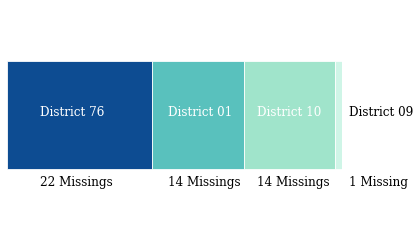

In [105]:
plt.rcParams["font.family"] = "serif"


na_df = pd.DataFrame({"District": ["76", "1", "10", "9"], "Count_NA": [22, 14, 14, 1]})
ax = na_df[["Count_NA"]].T.plot.barh(stacked=True, legend=False, color = ["#0D4C92", "#59C1BD", "#A0E4CB", "#CFF5E7"])
plt.xlabel("")
plt.ylabel("")
plt.xticks([]) 
plt.yticks([]) 
ax.set(xlim = [0, 51], title = "")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 


ax.text(5, 0, 'District 76', color = "white", size = 12)
ax.text(5, -0.32, '22 Missings', color = "black", size = 12)
ax.text(24.5, 0, 'District 01', color = "white", size = 12)
ax.text(24.5, -0.32, '14 Missings', color = "black", size = 12)
ax.text(38, 0, 'District 10', color = "white", size = 12)
ax.text(38, -0.32, '14 Missings', color = "black", size = 12)
ax.text(52, 0, 'District 09', color = "black", size = 12)
ax.text(52, -0.32, '1 Missing', color = "black", size = 12)

There are a lot more missing values in `Location Description`, `Longitude`, and `Latitude`. However, since this information is unrelated to our analysis at this point, we can simply leave them be.  

For the sake of our data cleaning and analysis, I proceed with dropping out these three variables.

In [ ]:
crime2 = crime.dropna(subset=['Ward', 'District', 'Community Area'])
crime2.isna().sum()

Case Number                  0
Date                         0
Primary Type                 0
Description                  0
Location Description      8024
Arrest                       0
Domestic                     0
Beat                         0
District                     0
Ward                         0
Community Area               0
Year                         0
Latitude                198673
Longitude               198673
dtype: int64

Next, we focus on converting variable types. This is comprised with three substeps: first, we convert `District`, `Ward`, and `Community Area` to integers; second, we make variable `Date` a datetime object, which is a date/time-specific type in Python.  

Let's start with the first step. Because there are multiple variables that need to be transformed, we apply a for-loop here. 

In [ ]:
for i in [8, 9, 10]:
   crime2.iloc[:,i] = crime2.iloc[:, i].astype(int)

c:\Users\liu00\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
#for j in [0,1,2,3,4, 7, 8, 9, 10, 11]:
#    crime.iloc[:,j] = crime.iloc[:,j].astype(str)

Now the second step:

In [ ]:
crime2.loc[:,"Date"] = pd.to_datetime(crime2["Date"], infer_datetime_format=True)

c:\Users\liu00\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


With another look of eyes, we are sure that all variables are in the right format. We are ready to move forward! How exciting!

In [ ]:
crime2.dtypes

Case Number                     object
Date                    datetime64[ns]
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                         int32
Ward                             int32
Community Area                   int32
Year                             int64
Latitude                       float64
Longitude                      float64
dtype: object

In [ ]:
crime2.to_csv("data/cleaned_crimes_from_2015.csv", index=False)

In [ ]:
crime2.to_pickle("data/cleaned_crimes_from_2015.pkl")

## Part III: Explorative Data Analysis:

Now it's finally the time to answer our questions posed in part II. 

We first load our cleaned dataset to the notebook. With 16 variables, there are a lot of questions that can be asked. I will center around questions that are of the most interest to me and probably add more later on, should the need arise. 

The section is structured around questions marked by subtitles. For each question, I will try to use a combination of table and graphics to answer.

In [4]:
import pickle

with open(path + 'cleaned_crimes_from_2015.pkl', 'rb') as f:
    crimes = pickle.load(f)
crimes.head(5)

,Case Number,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
0,HY411648,2015-09-05 13:30:00,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9,12,61,2015,41.815117,-87.670000
1,HY411615,2015-09-04 11:30:00,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15,29,25,2015,41.895080,-87.765400
2,JC213529,2018-09-01 00:01:00,THEFT,OVER $500,RESIDENCE,False,True,631,6,8,44,2018,NaN,NaN
3,HY411595,2015-09-05 12:45:00,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14,35,21,2015,41.937406,-87.716650
4,HY411610,2015-09-05 13:00:00,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15,28,25,2015,41.881903,-87.755121


### *Q1: Which year has the most crimes?*

Crime has been decreasing since the 90s and remaining relatively steady since mid-2000s. This broad trend speaks to both national and local levels (Chicago included). However, this is not to say crime number was the same for every year. In fact, on a micro time scale, such as a few months, 1 year, or 3 years, fluctuations arose in nearly all cities (changes over a few years can not be called trend, which must be established on a longer scale). How has the level of criminal activity changed in Chicago since 2015? This is a question that is very concerning to me.

As we can tell from the following table and graph, there were some minor variations on the total number of crimes in Chicago between 2015 and 2018, but overall, criminal activities were steady during this period, not a lot of increase nor decrease. Between 2018 and 2019, there was a 3 percent drop in crime numbers (or a reduction of 7557 crimes). The negative trend continuted after 2019, and the decrease was the highest between 2019 and 2020 (a 18.5% shrink within this time frame). 

A few reasons might contribute to this explanation. First is that in 2020, the noval COVID-19 virus broke out in the US, and Chicago was among the most affected areas. Following the coronavarius, the government issued the quarantine order, which encouraged people to reduce their outdoor actvities. When criminals were out of the street, criminal activies decreased consequentially. The trent whereas started in 2019, the year before the inciden, which is interesting. It is worth the time of the client to investigate what happened in 2019 that led to the trend. 

It is also possible, although to a less degree, that there was a change to CPD's CLEAR system, for example, there might have been an update to the system or that some crimes were codes in a new way, which caused the declination. Future investigation is needed should the time allows.

In [4]:
count_by_year = crimes.loc[:, "Year"].value_counts().sort_index(ascending=True).to_frame().iloc[:-1,:]
count_by_year = count_by_year.reset_index()
count_by_year.columns = ["Year", "Crime Counts"]
count_by_year

,Year,Crime Counts
0,2015,264698
1,2016,269751
2,2017,268984
3,2018,268667
4,2019,261110
5,2020,211881
6,2021,207872


[Text(0, 0, '0'),
 Text(0, 0, '50,000'),
 Text(0, 0, '100,000'),
 Text(0, 0, '150,000'),
 Text(0, 0, '200,000'),
 Text(0, 0, '250,000'),
 Text(0, 0, '300,000')]

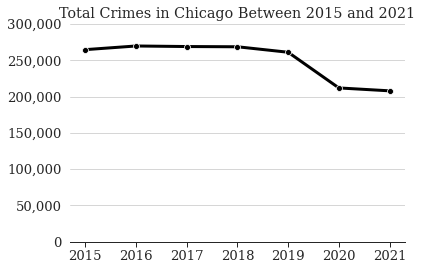

In [50]:
sns.set_context("paper", font_scale = 1.5)
sns.set_style("ticks")
plt.rcParams["font.family"] = "serif"

ax = sns.lineplot(x = "Year", y = "Crime Counts", data = count_by_year, marker = "o", color = "black", linewidth=3, markersize=6)
ax.set(ylim = [0, 300000], title = "Total Crimes in Chicago Between 2015 and 2021")

plt.ylabel("")
plt.xlabel("")
plt.grid(axis = 'y')

ax.yaxis.set_ticks_position('none') 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])

### *Q2: Which type of crime was the most common? Which was the least?*

Different crimes could be roughly divided into four categories: violent crimes, property crimes, crimes against public order, and others (misdemeanors and felonies utilize another classification system). There are other ways to classify crimes as well. For example, the well-known term "index crime", frequentially used by the FBI and other law enforcement agencies, refer to a series of crimes including murder, aggrevated assaults, rape, arsons, motor vehicle theft, bulgary, robberies, and larceny, which collectively, represent the most heinous and serious crimes. The eight categories above contain both violent crimes and property crimes and the overlapping of both. What was the most committed crimes in Chicagoland since 2015? Let's take a look.

By ranking all primary types of crimes according to their case counts, we found out that theft, battery, and criminal damage were the top-three most-occurred crimes, which in total represented over 50% of all crimes happened in Chicago during the period. Narcotics, drug-related offenses, was at the 6th place with 93098 counts. Homicide was at the 17th place with 5209 cases. 

We should be cautious in explaining our findings here for a few reasons. One is that Chicago Police Department coded crimes slightly differently than the FBI. For instance, the term "assault" represents both low-level assaults, which is usually misdemeanors, and aggrevated assaults, where bodily harms were often inflicted on the victims. The indistinction between these two types might pose important policy problems given how they differ legally. 

Moroever, we should be clear that the numbers illustrated what had been reported to the police, not what had really happened. Offense, especially sexual offenses and sexual batteries, were mostly unreported due to social embrassment and other reasons. Therefore, for a lot of crime types below, the real number might be even higher. 

Lastlt, a few groups, such as `CRIM SEXUAL ASSAULT` and `CRIMINAL SEXUAL ASSAULT`, refer to the same type of crime but under different categories. For a fully cleaned dataset that is published on the agency's offical website, the issue is less likely to be caused by negiligence of people who entered the data to the system (not impossible) and more likely to infer changes in the department's coding system. The specific reason behind repeated categories may need deeper investigations. 

In [ ]:
count_by_type = crime.loc[:, "Primary Type"].value_counts(ascending=False).to_frame()
count_by_type = count_by_type.reset_index()
count_by_type.columns = ["Type", "Crime Counts"]
count_by_type

# dictionary to make new variables

,Type,Crime Counts
0,THEFT,432786
1,BATTERY,360695
2,CRIMINAL DAMAGE,212646
3,ASSAULT,150235
4,DECEPTIVE PRACTICE,139787
5,OTHER OFFENSE,123634
6,NARCOTICS,93098
7,MOTOR VEHICLE THEFT,84547
8,BURGLARY,82726
9,ROBBERY,73141


In [ ]:
crime.loc[:, ["Primary Type", "Arrest"]].groupby(["Primary Type", "Arrest"]).size() #.sort_values(ascending=False)  

Primary Type       Arrest
ARSON              False       3257
                   True         333
ASSAULT            False     126471
                   True       23764
BATTERY            False     291118
                              ...  
STALKING           True         175
THEFT              False     394818
                   True       37968
WEAPONS VIOLATION  False      15267
                   True       32203
Length: 69, dtype: int64

### *Q3: Which police district faced the most crimes per capita since 2015? Which district was the safest?*

As we are able to tell from the horizontal bar chart below, crimes concentrated in police districts 11,6, 8, 4,7, 25. These districts all had over 100,000 criminal incidents since 2015, and together, they represented over 35% of all crimes that happened in Chicago since 2015. These districts locate in the South and West sides of Chicago. These regions are also the city's segregated and low-income areas, accompanied with high-level gang activities.  

By contrasts, police districts toward the bottom of this table are North and East areas where the socioeconomic level is significantly higher than the districts above. We may be able to draw the crime information on a map should we also acquire a geojson file that includes the geographic boundaries of each area.

It would also be interesting to look at the gang actvitity map and compare it with this one to find out to what degree, the information overlaps. 

In [ ]:
crimes.groupby(["Year","District"])["Description"].count().reset_index().groupby("District").mean()

In [8]:
count_by_district_avg = crimes.groupby(["District"])["Description"].count().reset_index()
count_by_district_avg = count_by_district_avg.groupby("District").mean().reset_index()
count_by_district_avg.columns = ["District", "Count"]
count_by_district_avg.Count = count_by_district_avg.Count.astype(int)
count_by_district_avg

,District,Count
0,1,99354
1,2,84488
2,3,92991
3,4,108570
4,5,85024
5,6,120459
6,7,101710
7,8,120079
8,9,85242
9,10,88536


In [21]:
count_by_district_avg.dtypes

District    int64
Count       int64
dtype: object

In [9]:
count_by_district_perc = count_by_district_avg.merge(district_pop, on='District', how='left')

In [36]:
count_by_district_perc

,District,Count,2010_pop
0,1,99354,62781
1,2,84488,95439
2,3,92991,75235
3,4,108570,123575
4,5,85024,74396
5,6,120459,90841
6,7,101710,71071
7,8,120079,247373
8,9,85242,165201
9,10,88536,118093


In [10]:
count_by_district_perc.loc[:, "Percent"] = count_by_district_perc.loc[:, "Count"]/count_by_district_perc.loc[:,"2010_pop"]
count_by_district_perc.loc[:, "Percent"] = round(count_by_district_perc.Percent,4)*1e2
count_by_district_perc = count_by_district_perc.sort_values(by = 'Percent', ascending = False)
count_by_district_perc.District = count_by_district_perc.District.apply(lambda x: "District " + str(x) + " ")

count_by_district_perc

,District,Count,2010_pop,Percent
10,District 11,132269,70474,187.68
0,District 1,99354,62781,158.25
6,District 7,101710,71071,143.11
5,District 6,120459,90841,132.60
13,District 15,76498,59458,128.66
2,District 3,92991,75235,123.60
4,District 5,85024,74396,114.29
1,District 2,84488,95439,88.53
3,District 4,108570,123575,87.86
16,District 18,99215,117041,84.77


[Text(0, 0, '0'),
 Text(0, 0, '25'),
 Text(0, 0, '50'),
 Text(0, 0, '75'),
 Text(0, 0, '100'),
 Text(0, 0, '125'),
 Text(0, 0, '150'),
 Text(0, 0, '175'),
 Text(0, 0, '200')]

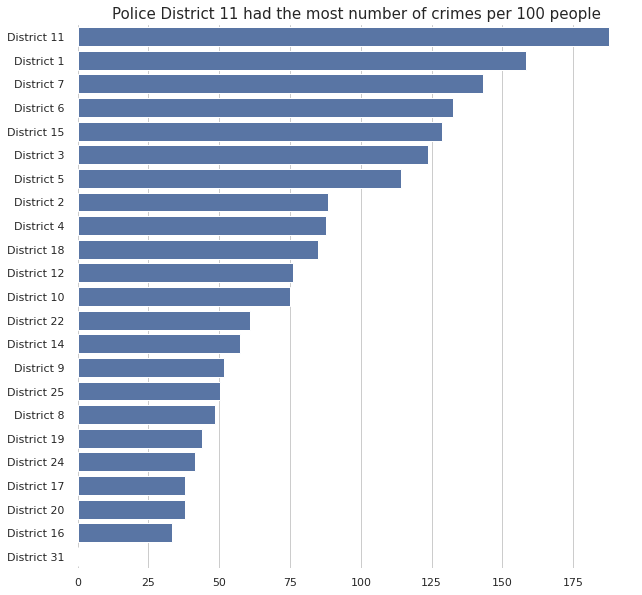

In [14]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.set_style("whitegrid")
ax = sns.barplot(y = "District", x = "Percent", data = count_by_district_perc, orient = "h", color = "b", order=count_by_district_perc.District)
plt.title("Police District 11 had the most number of crimes per 100 people", fontsize = 15)
plt.xlabel("")
plt.ylabel("")
sns.despine
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.gca().set_xticklabels(['{:,.0f}'.format(y) for y in plt.gca().get_xticks()])

### *Q4: Where crime usually occurred?*

The Chicago Police Department includes a very comprehensive list of locations in their database. To be more specific, there are close to 200 locations, including some category overlaps, which may be caused by the implementation of a new crime coding system within the department. Although we may love the comprehensiveness, coding these crimes in a more concise manner may give data analysts and researchers some leeways. For the sake of time, I wasn't able to go through all these 200ish locations and classify them into a few groups. However, this may be beneficial for the organization depending on the goal.

We should be aware that some locations had more crimes than others. As we are able to tell from the graph and table below, five locations, street, residence, apartment, sidewalk, and small retail stores represented a great majority (65%) of all crimes. If we include the miscellaneous category "Other", that will add another 2% of crime incidents and make the total share 67%. We may need to further break down by type of offenses in each location category to see what happened in these places. Just by looking at them, my guess is that a lot of assaults, robberies, thefts, and bulgeries contributed to the massive crime counts. 

In [ ]:
count_by_loc = crime.loc[:, "Location Description"].value_counts(ascending=False).to_frame()
count_by_loc = count_by_loc.reset_index()
count_by_loc.columns = ["Location", "Crime Counts"]
count_by_loc

,Location,Crime Counts
0,STREET,446248
1,RESIDENCE,315401
2,APARTMENT,286994
3,SIDEWALK,148431
4,OTHER,56004
...,...,...
191,CTA SUBWAY STATION,1
192,CLEANERS/LAUNDROMAT,1
193,POOLROOM,1
194,CHA PLAY LOT,1


In [ ]:
count_by_loc.iloc[:,0].to_list()

['STREET',
 'RESIDENCE',
 'APARTMENT',
 'SIDEWALK',
 'OTHER',
 'SMALL RETAIL STORE',
 'RESTAURANT',
 'PARKING LOT/GARAGE(NON.RESID.)',
 'ALLEY',
 'VEHICLE NON-COMMERCIAL',
 'DEPARTMENT STORE',
 'RESIDENTIAL YARD (FRONT/BACK)',
 'GAS STATION',
 'RESIDENCE PORCH/HALLWAY',
 'GROCERY FOOD STORE',
 'RESIDENCE-GARAGE',
 'SCHOOL, PUBLIC, BUILDING',
 'PARKING LOT / GARAGE (NON RESIDENTIAL)',
 'COMMERCIAL / BUSINESS OFFICE',
 'PARK PROPERTY',
 'CONVENIENCE STORE',
 'BAR OR TAVERN',
 'CTA TRAIN',
 'OTHER (SPECIFY)',
 'DRUG STORE',
 'RESIDENCE - PORCH / HALLWAY',
 'RESIDENCE - YARD (FRONT / BACK)',
 'BANK',
 'HOTEL/MOTEL',
 'RESIDENCE - GARAGE',
 'CTA BUS',
 'HOSPITAL BUILDING/GROUNDS',
 'CTA STATION',
 'CTA PLATFORM',
 'DRIVEWAY - RESIDENTIAL',
 'CHA APARTMENT',
 'SCHOOL, PUBLIC, GROUNDS',
 'POLICE FACILITY/VEH PARKING LOT',
 'VACANT LOT/LAND',
 'NURSING HOME/RETIREMENT HOME',
 'CTA BUS STOP',
 'ATHLETIC CLUB',
 'CHA PARKING LOT/GROUNDS',
 'HOSPITAL BUILDING / GROUNDS',
 'SCHOOL, PRIVATE, BUILDI

In [ ]:
from importlib import reload
reload(plt)

# To add labels to bars:
# ax = sns.barplot(x=x, y=y, hue=y, orient='h', dodge=False, ax=ax, palette='turbo')
# ax.tick_params(left=False, labelleft=False)
# for bars_group in ax.containers:
#    ax.bar_label(bars_group, padding=3, fontsize=15)  #this line

<module 'matplotlib.pyplot' from 'c:\\Users\\liu00\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

c:\Users\liu00\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-237-c669227239f3>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


[Text(0, 0.0, '0'),
 Text(0, 100000.0, '100,000'),
 Text(0, 200000.0, '200,000'),
 Text(0, 300000.0, '300,000'),
 Text(0, 400000.0, '400,000'),
 Text(0, 500000.0, '500,000')]

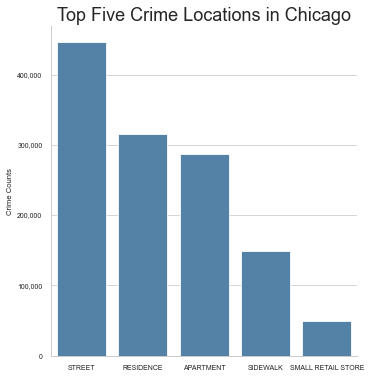

In [ ]:
sns.set_context("paper", font_scale = .8)
sns.set_style("whitegrid")
#sns.set(font_scale=2)
sns.catplot("Location", "Crime Counts", data= count_by_loc.iloc[[0,1,2,3,5],:], kind = "bar", color = "steelblue")
plt.xlabel("")
plt.title('Top Five Crime Locations in Chicago', fontsize = 18)

plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])

In [ ]:
sum(count_by_loc.iloc[[0,1,2,3,5],1])/sum(count_by_loc.iloc[:,1])

0.6503127927047406

In [ ]:
sum(count_by_loc.iloc[0:6,1])/sum(count_by_loc.iloc[:,1])

0.6795527236616639